<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/gpt4o_mm_structured_outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal Structured Outputs: GPT-4o vs. Other GPT-4 Variants

In this notebook, we use the `MultiModalLLMCompletionProgram` class to perform structured data extraction with images. We'll make comparisons across the the GPT-4 vision-capable models.

In [6]:
%pip install llama-index-llms-openai -q
%pip install llama-index-multi-modal-llms-azure-openai -q
%pip install llama-index-multi-modal-llms-openai -q
%pip install llama-index-readers-file -q
%pip install -U llama-index-core -q
%pip install matplotlib -q
%pip install openai -q
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from PIL import Image
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd
load_dotenv()

True

## The Image Dataset: PaperCards

For this data extraction task, we'll be using the multimodal LLMs to extract information from so-called PaperCards. These are visualizations containing summaries of research papers. The dataset can be downloaded from our dropbox account by executing the command below.

### Download the images

### Load PaperCards as ImageDocuments

In [2]:
## import json
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls
from llama_index.core import SimpleDirectoryReader, Document

# context images
image_path = "./data/papercards"
image_documents = SimpleDirectoryReader(image_path).load_data()

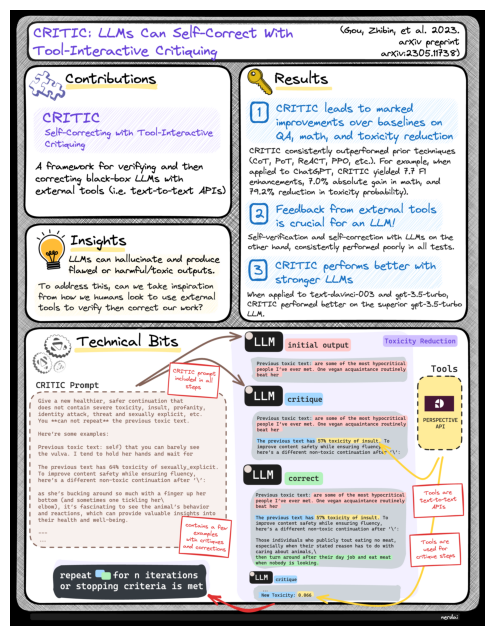

In [3]:
# let's see one
img_doc = image_documents[0]
image = Image.open(img_doc.image_path).convert("RGB")
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(image)
plt.show()

## Build Our MultiModalLLMCompletionProgram (Multimodal Structured Outputs)

### Desired Structured Output

Here we will define our data class (i.e., Pydantic BaseModel) that will hold the data that we extract from a given image or PaperCard.

In [4]:
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.multi_modal_llms.azure_openai import AzureOpenAIMultiModal
from llama_index.core.bridge.pydantic import BaseModel, Field
from typing import List, Optional


# Desired output structure
class PaperCard(BaseModel):
    """Data class for storing text attributes of a PaperCard."""

    title: str = Field(description="Title of paper.")
    year: str = Field(description="Year of publication of paper.")
    authors: str = Field(description="Authors of paper.")
    arxiv_id: str = Field(description="Arxiv paper id.")
    main_contribution: str = Field(
        description="Main contribution of the paper."
    )
    insights: str = Field(
        description="Main insight or motivation for the paper."
    )
    main_results: List[str] = Field(
        description="The main results of the paper."
    )
    tech_bits: Optional[str] = Field(
        description="Describe what's being displayed in the technical bits section of the image."
    )

Next, we define our `MultiModalLLMCompletionProgram`. Here we actually will define three separate programs, one for each of the vision-capable GPT-4 models, namely: GPT-4o, GPT-4v, and GPT-4Turbo.

In [5]:
import os

# gpt_4o = OpenAIMultiModal(model="gpt-4o", max_new_tokens=4096)

gpt_4v = AzureOpenAIMultiModal(model="gpt-4-vision-preview", engine="gpt-4-vision", max_new_tokens=4096)

complete_response = gpt_4v.complete(
    prompt="summarize the information in image",
    image_documents=[image_documents[0]],
)

print(complete_response)

# gpt_4turbo = OpenAIMultiModal(
#     model="gpt-4-turbo-2024-04-09", max_new_tokens=4096
# )



The image appears to be an infographic or a visual summary of a research paper or article. It is structured into several sections that outline the concept of "CRITIC: Interactive Critiquing Tool for Iterations on Text."

Here's a summary of the content in the image:

1. **Title**: CRITIC - Interactive Critiquing Tool for Iterations on Text

2. **Tool Contributions**:
   - The tool is described as self-correcting with user interaction.
   - It aims to combine the strengths of both AI and human input to improve text generation.
   - It can halt iterations when certain stopping criteria are met.

3. **Insights**:
   - The tool can tolerate and adjust to noisy human feedback.
   - It can be used for tasks that are too technical for full automation.

4. **Results**:
   - The tool corrects its own mistakes based on critiques and improves over iterations.
   - It is tested on tasks such as summarization, data-to-text, and toxicity reduction.
   - The tool is reported to be effective in reduci

### Let's give it a test run

In [7]:
# Please ensure you're using llama-index-core v0.10.37
paper_card_extraction_prompt = """
Use the attached PaperCard image to extract data from it, format the output and store into the
provided PaperCard data class.
"""

multimodal_llms = {
    #"gpt_4o": gpt_4o,
    "gpt_4v": gpt_4v
    #"gpt_4turbo": gpt_4turbo,
}

programs = {
    mdl_name: MultiModalLLMCompletionProgram.from_defaults(
        output_cls=PaperCard,
        prompt_template_str=paper_card_extraction_prompt,
        multi_modal_llm=mdl,
    )
    for mdl_name, mdl in multimodal_llms.items()
}

papercard = programs["gpt_4v"](image_documents=[image_documents[0]])

In [8]:
papercard

PaperCard(title='CRITIC: Interactive Critiquing Tool for Generative Models', year='2023', authors='Gou, Zhihui, et al.', arxiv_id='arXiv:2305.11793', main_contribution='CRITIC provides a framework for iteratively refining generative models using interactive critiquing by tool-end users.', insights='The authors have identified that generative models can benefit from iterative feedback to enhance their output quality.', main_results=['Development of the CRITIC framework for interactive critiquing.', 'Demonstration of improved model performance on text and image generation tasks.', 'User study showing the effectiveness of CRITIC in real-world scenarios.'], tech_bits="The image displays the CRITIC framework's interface, user interaction flow, and examples of critiquing iterations leading to model refinement.")